In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class NaiveBayesContinuous:
    def __init__(self, kernel_smoothing=False):
        """Inicjalizacja klasyfikatora. Jeśli kernel_smoothing=True, używa KDE."""
        self.kernel_smoothing = kernel_smoothing
        self.classes_ = None
        self.class_priors_ = None
        self.models_ = {}

    def fit(self, X, y, priors=None):
        """
        Uczy klasyfikator na podstawie danych treningowych.
        :param X: macierz cech
        :param y: etykiety klas
        :param priors: słownik {klasa: prawdopodobieństwo}
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        self.class_priors_ = {}

        for cls in self.classes_:
            X_c = X[y == cls]
            self.models_[cls] = []
            self.class_priors_[cls] = priors.get(cls, len(X_c) / n_samples) if priors else len(X_c) / n_samples

            for feature in range(n_features):
                if self.kernel_smoothing:
                    kde = gaussian_kde(X_c[:, feature])
                    self.models_[cls].append(kde)
                else:
                    mean = X_c[:, feature].mean()
                    std = X_c[:, feature].std() + 1e-6  
                    self.models_[cls].append((mean, std))

    def predict_proba(self, X):
        """Zwraca prawdopodobieństwa a posteriori dla każdej próbki."""
        probs = []
        for x in X:
            class_probs = {}
            for cls in self.classes_:
                prior = self.class_priors_[cls]
                likelihood = 1.0
                for i, feature_value in enumerate(x):
                    if self.kernel_smoothing:
                        kde = self.models_[cls][i]
                        likelihood *= kde.evaluate([feature_value])[0]
                    else:
                        mean, std = self.models_[cls][i]
                        likelihood *= norm.pdf(feature_value, mean, std)
                class_probs[cls] = prior * likelihood
            total = sum(class_probs.values()) + 1e-9
            for cls in class_probs:
                class_probs[cls] /= total
            probs.append(class_probs)
        return probs

    def predict(self, X):
        """Zwraca przewidywane etykiety klas."""
        probs = self.predict_proba(X)
        return np.array([max(p, key=p.get) for p in probs])

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.classes_, yticklabels=self.classes_)
        plt.xlabel("Predykcja")
        plt.ylabel("Rzeczywista")
        plt.title("Macierz pomyłek")
        plt.tight_layout()
        plt.show()

    def plot_posterior_heatmap(self, X_sample):
        probs = self.predict_proba([X_sample])[0]
        classes = self.classes_
        values = [probs.get(cls, 0.0) for cls in classes] 
        
        plt.figure(figsize=(6, 1))
        sns.heatmap([values], annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=classes, cbar=False)
        plt.yticks([])
        plt.title("Prawdopodobieństwa a posteriori")
        plt.tight_layout()
        plt.show()

    def plot_decision_boundary_2d(self, X, y, resolution=0.2, test_point=None):
        if X.shape[1] != 2:
            raise ValueError("Wizualizacja w tej metodzie działa tylko dla 2 cech!")

        cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])
        cmap_bold = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                             np.arange(y_min, y_max, resolution))

        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid_points)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=(8, 6))
        plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)
        scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)

        if test_point is not None:
            predicted_class = self.predict([test_point])[0]
            print(f"Punkt testowy został zaklasyfikowany do klasy: {predicted_class}")
            plt.scatter(test_point[0], test_point[1], c='black', s=100, marker='X', label="Punkt testowy")


        plt.xlabel("Poziom glukozy (standaryzowany)", fontsize=12)
        plt.ylabel("BMI (standaryzowany)", fontsize=12)
        plt.title("Granica decyzyjna - cechy: Glukoza, BMI", fontsize=14)

        handles, _ = scatter.legend_elements()
        labels = [f"Klasa {cls} ({'chory' if cls == 1 else 'zdrowy'})" for cls in self.classes_]
        plt.legend(handles=handles, labels=labels, title="Legenda", fontsize=10, title_fontsize=11)
        
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    def plot_decision_boundary_3d(self, X, y, resolution=0.2, test_point=None):
        if X.shape[1] != 3:
            raise ValueError("Wizualizacja w tej metodzie działa tylko dla 3 cech!")

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

        xx, yy, zz = np.meshgrid(
            np.arange(x_min, x_max, resolution),
            np.arange(y_min, y_max, resolution),
            np.arange(z_min, z_max, resolution)
        )

        grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
        Z = self.predict(grid_points)
        Z = np.array(Z)

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        colors = np.array(['#FF0000', '#0000FF', '#00FF00'])
        color_vals = colors[Z.astype(int)] if len(self.classes_) <= 3 else Z

        ax.scatter(
            grid_points[:, 0], grid_points[:, 1], grid_points[:, 2],
            c=color_vals, alpha=0.08, s=2, label="Obszary decyzyjne"
        )

        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm, edgecolor='k', s=60, label="Dane treningowe")

        if test_point is not None:
            predicted_class = self.predict([test_point])[0]
            print(f"Punkt testowy został zaklasyfikowany do klasy: {predicted_class}")
            ax.scatter(test_point[0], test_point[1], test_point[2],
                       c='black', s=100, marker='X', label="Punkt testowy")

        ax.set_xlabel("Poziom glukozy (standaryzowany)")
        ax.set_ylabel("BMI (standaryzowany)")
        ax.set_zlabel("Wiek (standaryzowany)")
        ax.set_title("Granica decyzyjna - cechy: Glukoza, BMI, Wiek")
        ax.legend()
        plt.tight_layout()
        plt.show()

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
col_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
             'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=col_names)

X = df.iloc[:, :-1].values
y = df['Outcome'].values
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

nb = NaiveBayesContinuous(kernel_smoothing=False)
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       151
           1       0.62      0.66      0.64        80

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.75       231



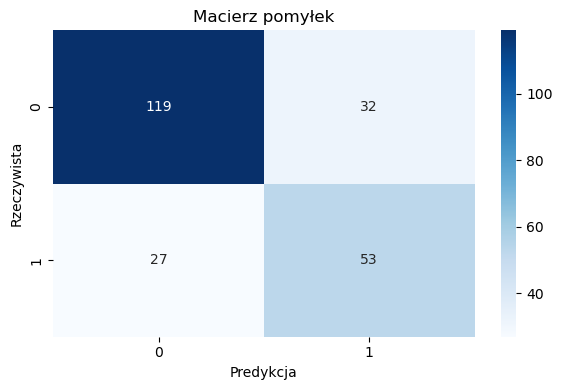

In [5]:
nb.plot_confusion_matrix(y_test, y_pred)

In [6]:
# nb.plot_posterior_heatmap(X_test[0])
def plot_heatmap_for_index(index):
    sample = X_test[index]
    nb.plot_posterior_heatmap(sample)
interact(plot_heatmap_for_index, index=IntSlider(min=0, max=len(X_test)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='index', max=230), Output()), _dom_classes=('widget-inter…

In [7]:
X_2d = X_scaled[:, [1, 5]]
nb_2d = NaiveBayesContinuous(kernel_smoothing=False)
nb_2d.fit(X_2d, y)

def update_plot_2d(index):
    test_point = X_2d[index]
    nb_2d.plot_decision_boundary_2d(X_2d, y, test_point=test_point)

interact(update_plot_2d, index=widgets.IntSlider(min=0, max=len(X_2d)-1, step=1, value=0));
# nb_2d.plot_decision_boundary_2d(X_2d, y, test_point=X_2d[0])

interactive(children=(IntSlider(value=0, description='index', max=767), Output()), _dom_classes=('widget-inter…

In [8]:
X_3d = X_scaled[:, [1, 5, 7]]
nb_3d = NaiveBayesContinuous(kernel_smoothing=False)
nb_3d.fit(X_3d, y)

def update_plot_3d(index):
    test_point = X_3d[index]
    nb_3d.plot_decision_boundary_3d(X_3d, y, test_point=test_point)

interact(update_plot_3d, index=widgets.IntSlider(min=0, max=len(X_3d)-1, step=1, value=0))
# nb_3d.plot_decision_boundary_3d(X_3d, y, test_point=X_3d[0])

interactive(children=(IntSlider(value=0, description='index', max=767), Output()), _dom_classes=('widget-inter…

<function __main__.update_plot_3d(index)>